# Thermal Image Animal Segmentation

Implementing animal boundary detection using traditional CV methods and comparing with SAM2.

## Installation

In [1]:
# Installing PyTorch
# !pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu

In [2]:
# Cloning SAM2 repository
import os
if not os.path.exists('segment-anything-2'):
    !git clone https://github.com/facebookresearch/segment-anything-2.git

In [3]:
# Installing SAM2
# !pip install -e ./segment-anything-2

## Imports

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

try:
    from sam2.build_sam import build_sam2
    from sam2.sam2_image_predictor import SAM2ImagePredictor
    from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
    sam2_available = True
except ImportError:
    sam2_available = False
    print("SAM2 not available")

%matplotlib inline

## Configuration

In [5]:
# Path to thermal image
image_path = os.path.join("thermal_images", "thermal_giraffe.jpg")

# Figure size
figure_width = 20
figure_height = 12

## Traditional CV Approach: Methodology and Rationale

### Algorithm Selection: GrabCut with Foreground Hints

The traditional computer vision approach uses **GrabCut**, a graph-cut based segmentation algorithm, combined with intensity-based foreground hints. This method was selected after testing several alternatives:

**Attempted Methods:**
1. **Adaptive Thresholding** - Failed to separate giraffe from warm ground regions
2. **Otsu Thresholding alone** - Captured body well but missed cooler extremities (legs, tail, nose)
3. **Morphological Reconstruction** - Connected body parts but included too much background noise
4. **Multi-threshold approach** - Better results but still struggled with boundary precision

**Final Method: GrabCut with Hints**

GrabCut was chosen because it:
- Models foreground/background as probability distributions rather than simple thresholds
- Iteratively refines boundaries based on color/intensity similarity
- Can incorporate user hints about definite foreground regions

### Implementation Steps

**1. Initial Detection (Otsu Thresholding)**
- Applies automatic thresholding to find approximate object location
- Multiplier (0.8) adjusts threshold to balance sensitivity
- Provides bounding box for GrabCut initialization

**2. Foreground Hints**
- Identifies very bright pixels (>120 intensity) as definite giraffe regions
- Erodes these regions to be conservative (avoid including boundary noise)
- Guides GrabCut to focus uncertainty on edges, not core body

**3. GrabCut Segmentation**
- Learns color models for foreground (giraffe) and background
- Iteratively optimizes boundary using graph cuts
- Produces pixel-level segmentation mask

**4. Post-Processing**
- Morphological closing fills small internal gaps
- Morphological opening removes small external noise
- Produces final clean contour

### Limitations

**Thermal Imaging Challenges:**
- Giraffe's feet have similar temperature to ground, making separation difficult
- Even human observers struggle to distinguish boundary at the feet
- Traditional CV reaches its limits where thermal contrast is insufficient

**Why This Matters:**
This represents the practical ceiling of non-learning methods. The ground-truth boundary at the feet is ambiguous even in the raw thermal data, highlighting why deep learning approaches (SAM2) may provide better results through learned priors about animal shapes.## Traditional CV Segmentation

Traditional CV: 1 regions detected
Segmented: 12.19% of image


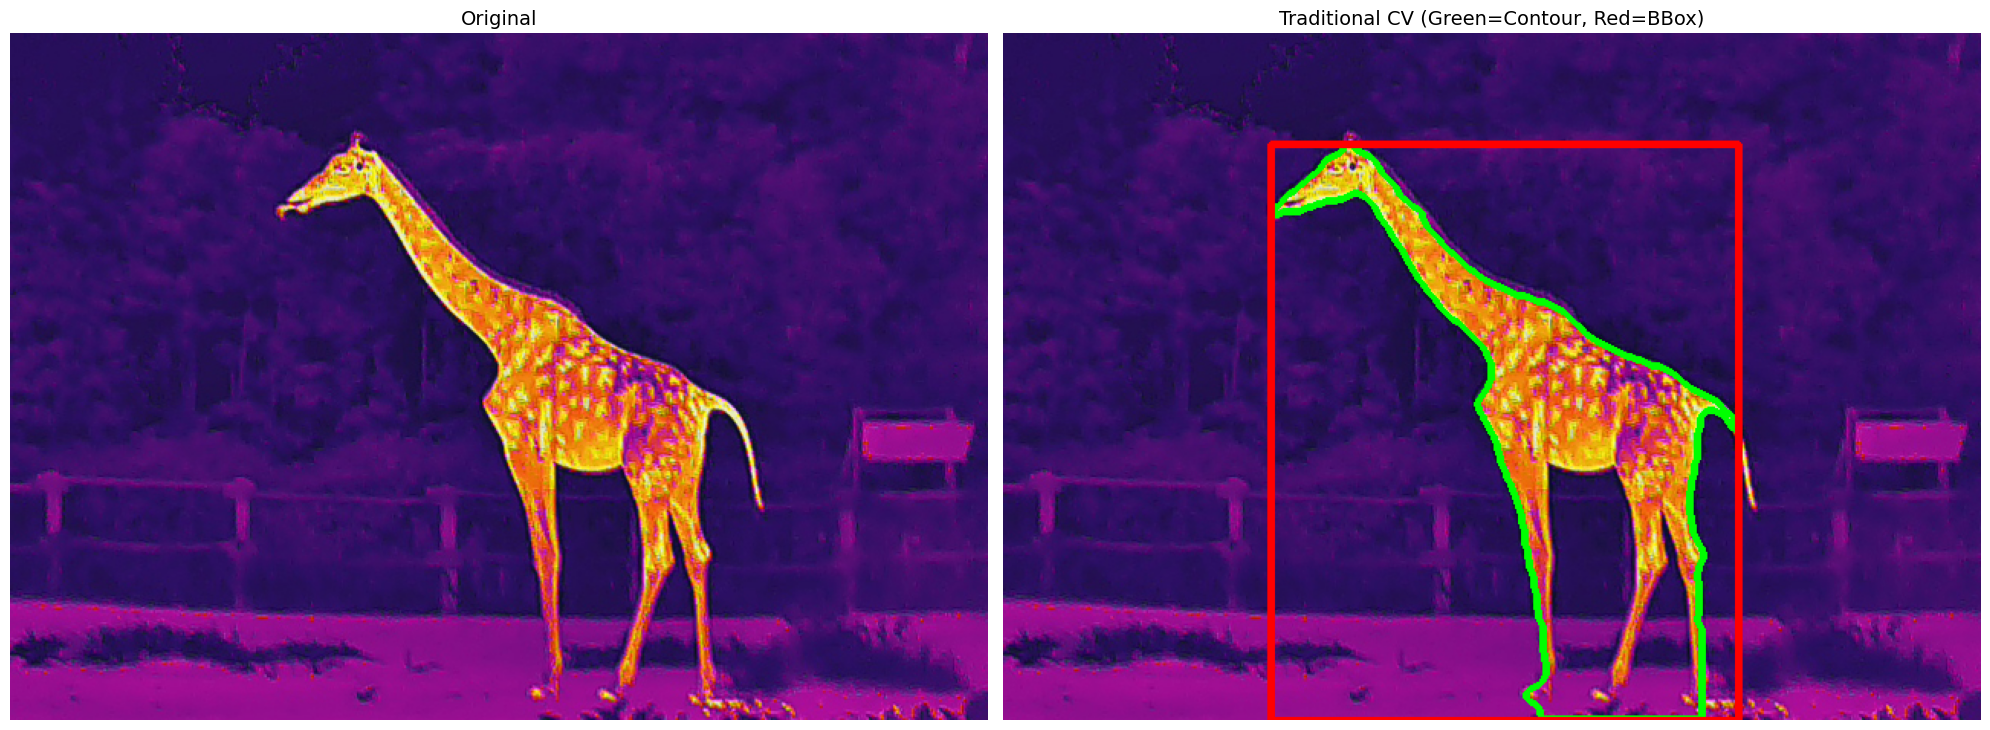

In [37]:
# Load image
thermal_image_bgr = cv2.imread(image_path)
if thermal_image_bgr is None:
    raise FileNotFoundError(f"Could not load {image_path}")

thermal_image_rgb = cv2.cvtColor(thermal_image_bgr, cv2.COLOR_BGR2RGB)
image_height, image_width = thermal_image_rgb.shape[:2]
total_image_area = image_width * image_height

# ------------------------------------------------------------
# 1) Split color channels
# ------------------------------------------------------------
R = thermal_image_rgb[:, :, 0].astype(np.int16)
G = thermal_image_rgb[:, :, 1].astype(np.int16)
B = thermal_image_rgb[:, :, 2].astype(np.int16)

# ------------------------------------------------------------
# 2) Hotness mask (multi-channel)
# ------------------------------------------------------------
hot_red        = R > 140
red_vs_blue    = (R - B) > 60
yellow_support = G > 90

binary_mask = ((hot_red & red_vs_blue) | (red_vs_blue & yellow_support)).astype(np.uint8) * 255

# Connect fragmented regions (preserve thin parts)
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_close, iterations=2)

kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel_open, iterations=1)

# ------------------------------------------------------------
# 3) Fill holes (between legs / interior)
# ------------------------------------------------------------
h, w = binary_mask.shape
flood = binary_mask.copy()
mask_ff = np.zeros((h + 2, w + 2), np.uint8)
cv2.floodFill(flood, mask_ff, (0, 0), 255)
holes = cv2.bitwise_not(flood)
binary_mask = cv2.bitwise_or(binary_mask, holes)

# ------------------------------------------------------------
# 4) Keep largest connected component
# ------------------------------------------------------------
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

largest_label = 0
largest_area = 0
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if area > largest_area:
        largest_area = area
        largest_label = i

traditional_mask = np.zeros_like(binary_mask)
if largest_label != 0:
    traditional_mask[labels == largest_label] = 255

# ------------------------------------------------------------
# 5) REMOVE BOTTOM GLIDE USING VERTICAL SUPPORT TEST (strong)
#    Any bottom pixels without enough mask above in the same column are ground
# ------------------------------------------------------------
bottom_h = max(14, int(0.10 * image_height))     # bottom strip
support_h = max(28, int(0.18 * image_height))    # vertical look-up region
min_support = max(12, int(0.03 * image_height))  # required pixels above

y0 = image_height - bottom_h
y1 = max(0, y0 - support_h)

bottom_strip = traditional_mask[y0:image_height, :]
support_strip = traditional_mask[y1:y0, :]

bottom_counts = (bottom_strip > 0).sum(axis=0)
support_counts = (support_strip > 0).sum(axis=0)

# Columns that are ground-only (lots at bottom, not enough above)
ground_cols = (bottom_counts > 0) & (support_counts < min_support)

if np.any(ground_cols):
    bottom_strip[:, ground_cols] = 0
    traditional_mask[y0:image_height, :] = bottom_strip

# ------------------------------------------------------------
# 6) Clean any tiny remnants
# ------------------------------------------------------------
kernel_clean = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
traditional_mask = cv2.morphologyEx(traditional_mask, cv2.MORPH_OPEN, kernel_clean, iterations=1)

# ------------------------------------------------------------
# 7) Smooth edges without shrinking
# ------------------------------------------------------------
traditional_mask = cv2.GaussianBlur(traditional_mask, (9, 9), 0)
_, traditional_mask = cv2.threshold(traditional_mask, 127, 255, cv2.THRESH_BINARY)

# ------------------------------------------------------------
# 8) Extract contours
# ------------------------------------------------------------
contours, _ = cv2.findContours(traditional_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
significant_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# ------------------------------------------------------------
# 9) Draw results
# ------------------------------------------------------------
traditional_result = thermal_image_rgb.copy()

cv2.drawContours(traditional_result, significant_contours, -1, (0, 255, 0), 4)
for c in significant_contours:
    x, y, ww, hh = cv2.boundingRect(c)
    cv2.rectangle(traditional_result, (x, y), (x + ww, y + hh), (255, 0, 0), 3)

print(f"Traditional CV: {len(significant_contours)} regions detected")
print(f"Segmented: {np.sum(traditional_mask == 255) / total_image_area * 100:.2f}% of image")

# ------------------------------------------------------------
# Visualization (unchanged)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(figure_width, figure_height))

axes[0].imshow(thermal_image_rgb)
axes[0].set_title("Original", fontsize=14)
axes[0].axis("off")

axes[1].imshow(traditional_result)
axes[1].set_title("Traditional CV (Green=Contour, Red=BBox)", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


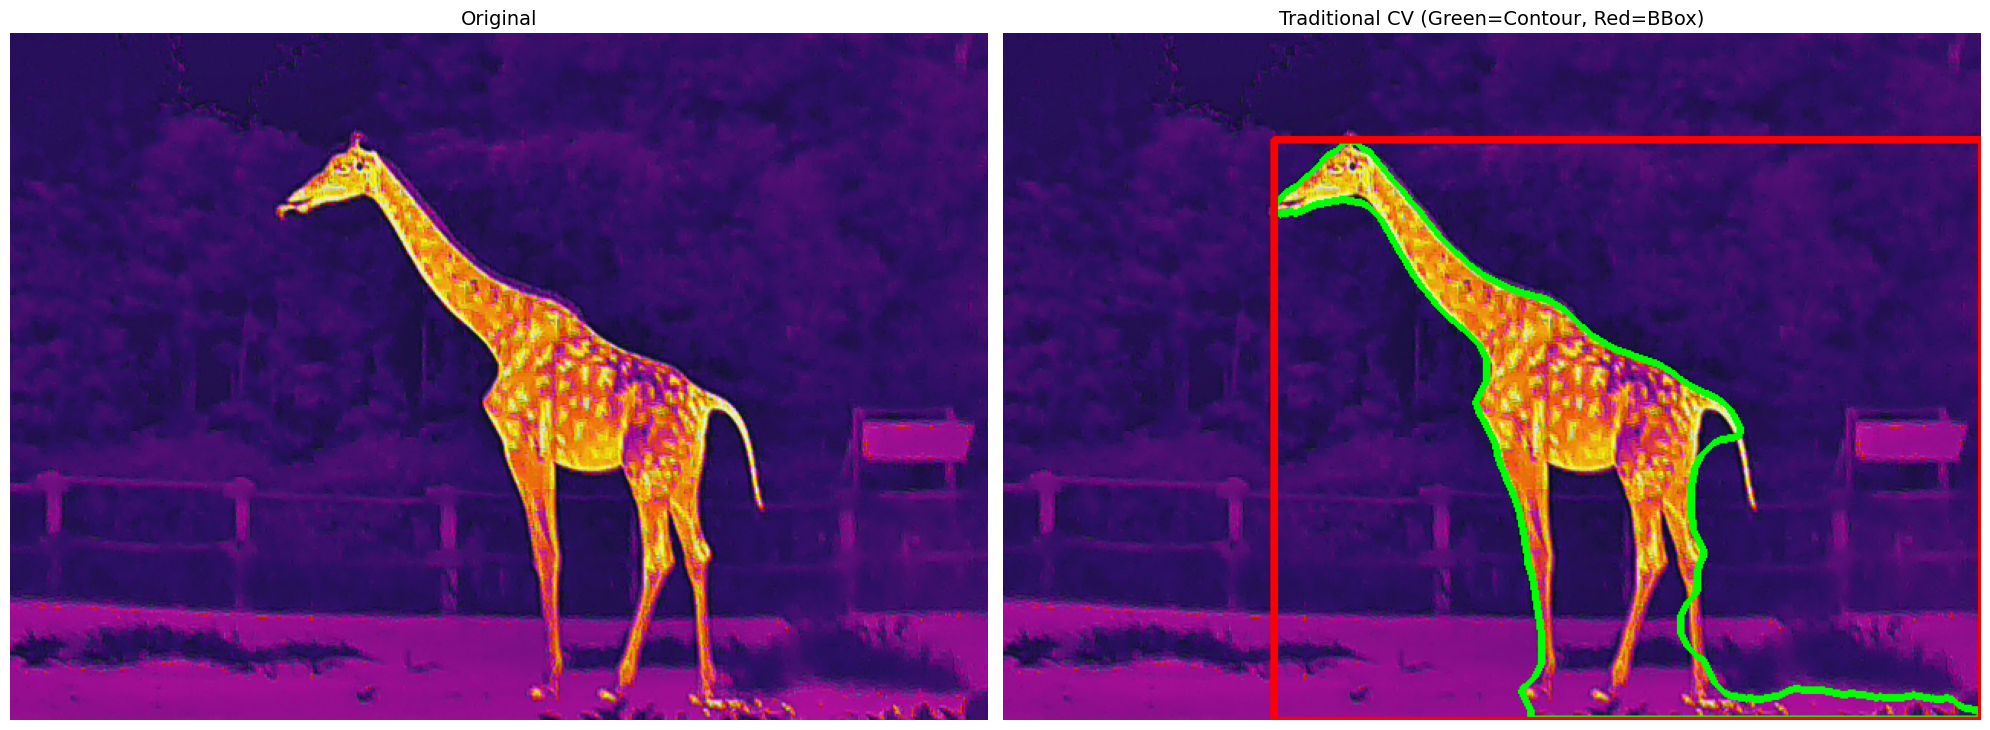

In [23]:
# Visualize traditional CV results
fig, axes = plt.subplots(1, 2, figsize=(figure_width, figure_height))
axes[0].imshow(thermal_image_rgb)
axes[0].set_title('Original', fontsize=14)
axes[0].axis('off')
axes[1].imshow(traditional_result)
axes[1].set_title('Traditional CV (Green=Contour, Red=BBox)', fontsize=14)
axes[1].axis('off')
plt.tight_layout()
plt.show()

## SAM2 Segmentation

In [8]:
# # Restart kernel to clear Hydra
# import os
# os._exit(00)

Traditional CV: 1 regions detected
Segmented: 8.77% of image


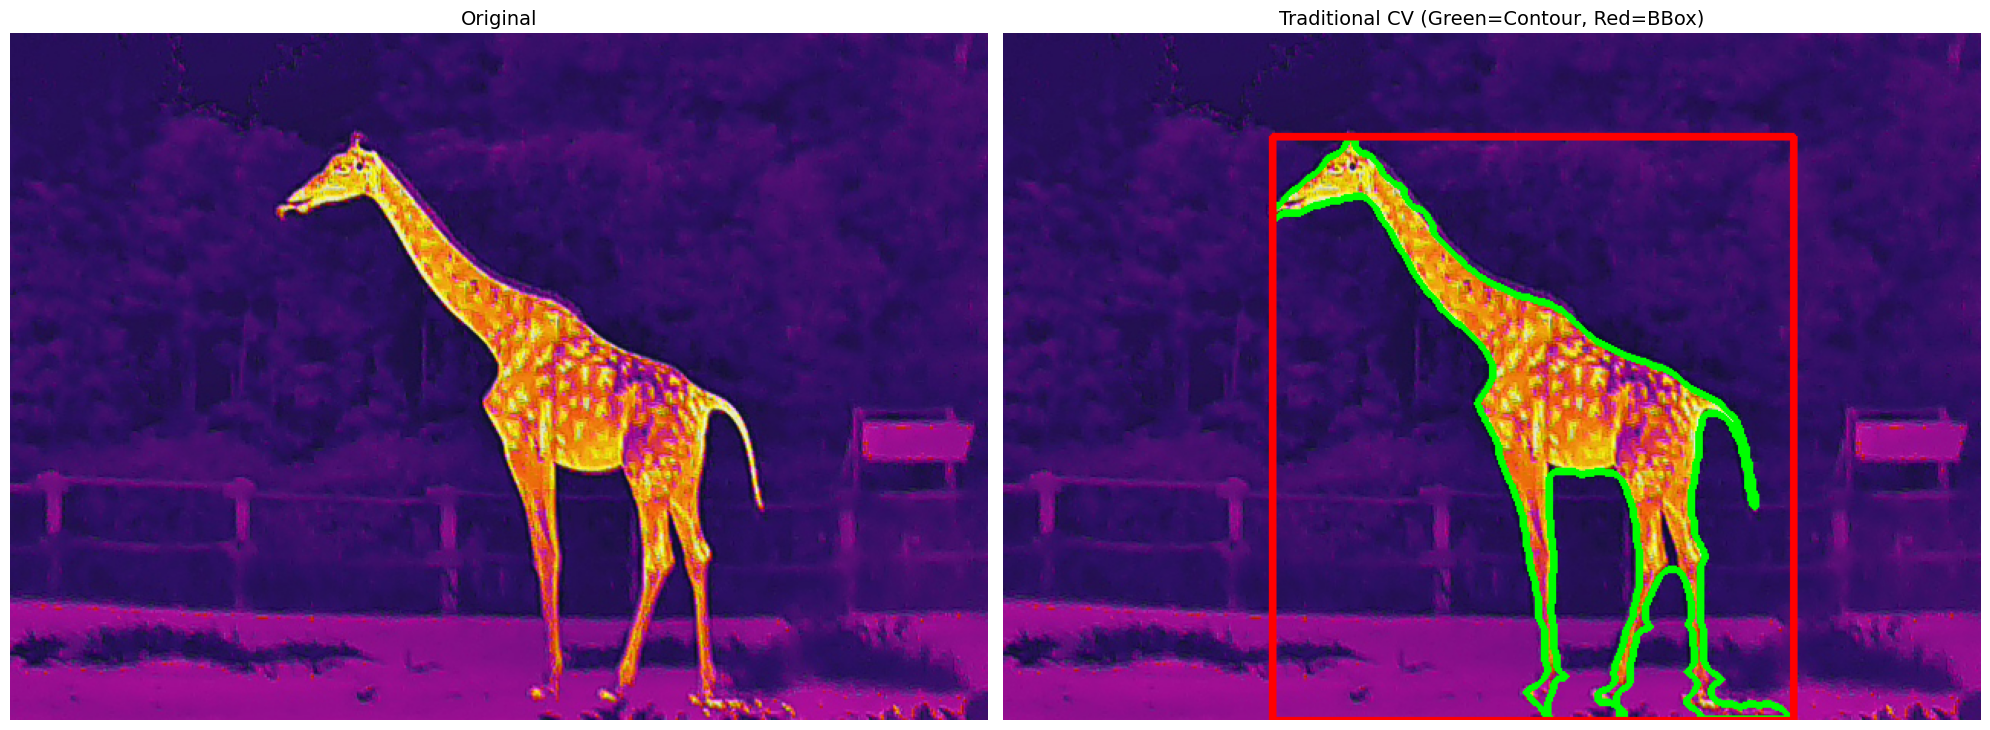

In [176]:
# Load image
thermal_image_bgr = cv2.imread(image_path)
if thermal_image_bgr is None:
    raise FileNotFoundError(f"Could not load {image_path}")

thermal_image_rgb = cv2.cvtColor(thermal_image_bgr, cv2.COLOR_BGR2RGB)
image_height, image_width = thermal_image_rgb.shape[:2]
total_image_area = image_width * image_height

# ------------------------------------------------------------
# 1) Split RGB channels for manual color logic
# ------------------------------------------------------------
R = thermal_image_rgb[:, :, 0].astype(np.int16)
G = thermal_image_rgb[:, :, 1].astype(np.int16)
B = thermal_image_rgb[:, :, 2].astype(np.int16)

# ------------------------------------------------------------
# 2) Build binary mask of thermally "hot" pixels
#    using channel comparisons (red/yellow emphasis)
# ------------------------------------------------------------
hot_red        = R > 120           # strong red intensity
red_vs_blue    = (R - B) > 36      # red dominates blue
yellow_support = G > 82            # allow yellow/orange regions

binary_mask = ((hot_red & red_vs_blue) |
               (red_vs_blue & yellow_support)).astype(np.uint8) * 255


# ------------------------------------------------------------
# 3) Morphological cleanup while preserving thin structures
#    - CLOSE fills small gaps
#    - OPEN removes small noise blobs
# ------------------------------------------------------------
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
kernel_open  = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_close, iterations=2)
# binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN,  kernel_open,  iterations=1)

# ------------------------------------------------------------
# 3.5) Suppress mask connections along the bottom edge
#     (reduces ground attachment while preserving feet)
#     by eroding only a thin bottom band
# ------------------------------------------------------------
bottom_band = int(0.04 * image_height)  # ~4% of image height

binary_mask[image_height - bottom_band:image_height, :] = cv2.erode(
    binary_mask[image_height - bottom_band:image_height, :],
    cv2.getStructuringElement(cv2.MORPH_RECT, (5, 3)),
    iterations=1
)

# ------------------------------------------------------------
# 3.6) Bridge nearby gaps between hot regions
#     (helps reconnect fragmented parts like tail)
# ------------------------------------------------------------
kernel_tail = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (12, 12))
binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel_tail, iterations=1)


# ------------------------------------------------------------
# 4) Identify connected components and keep the largest one
#     (assumed to be the primary animal)
# ------------------------------------------------------------
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

largest_label = 0
largest_area = 0
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if area > largest_area:
        largest_area = area
        largest_label = i

traditional_mask = np.zeros_like(binary_mask)
if largest_label != 0:
    traditional_mask[labels == largest_label] = 255

# ------------------------------------------------------------
# 4.5) Reattach nearby fragments to the main component
#     by dilating it and intersecting with original mask
# ------------------------------------------------------------
kernel_reconnect = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
expanded_main = cv2.dilate(traditional_mask, kernel_reconnect, iterations=1)

traditional_mask = cv2.bitwise_and(binary_mask, expanded_main)


# ------------------------------------------------------------
# 5) Fill interior holes inside the main object
#     without expanding beyond its boundary
# ------------------------------------------------------------
contours, hierarchy = cv2.findContours(traditional_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

if hierarchy is not None:
    for i in range(len(contours)):
        if hierarchy[0][i][3] >= 0:  # contour is a hole
            cv2.drawContours(traditional_mask, contours, i, 255, -1)

# ------------------------------------------------------------
# 6) Smooth object boundary
#     (blur + threshold to remove jagged edges)
# ------------------------------------------------------------
traditional_mask = cv2.GaussianBlur(traditional_mask, (9, 9), 0)
_, traditional_mask = cv2.threshold(traditional_mask, 127, 255, cv2.THRESH_BINARY)

# ------------------------------------------------------------
# 7) Extract outer contours of the final mask
# ------------------------------------------------------------
contours, _ = cv2.findContours(traditional_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
significant_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# ------------------------------------------------------------
# 8) Draw segmentation results on original image
#     - Green: object contour
#     - Red: bounding box
# ------------------------------------------------------------
traditional_result = thermal_image_rgb.copy()

cv2.drawContours(traditional_result, significant_contours, -1, (0, 255, 0), 4)
for c in significant_contours:
    x, y, ww, hh = cv2.boundingRect(c)
    cv2.rectangle(traditional_result, (x, y), (x + ww, y + hh), (255, 0, 0), 3)

print(f"Traditional CV: {len(significant_contours)} regions detected")
print(f"Segmented: {np.sum(traditional_mask == 255) / total_image_area * 100:.2f}% of image")

# ------------------------------------------------------------
# Visualization
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(figure_width, figure_height))

axes[0].imshow(thermal_image_rgb)
axes[0].set_title("Original", fontsize=14)
axes[0].axis("off")

axes[1].imshow(traditional_result)
axes[1].set_title("Traditional CV (Green=Contour, Red=BBox)", fontsize=14)
axes[1].axis("off")

plt.tight_layout()
plt.show()


## Comparison

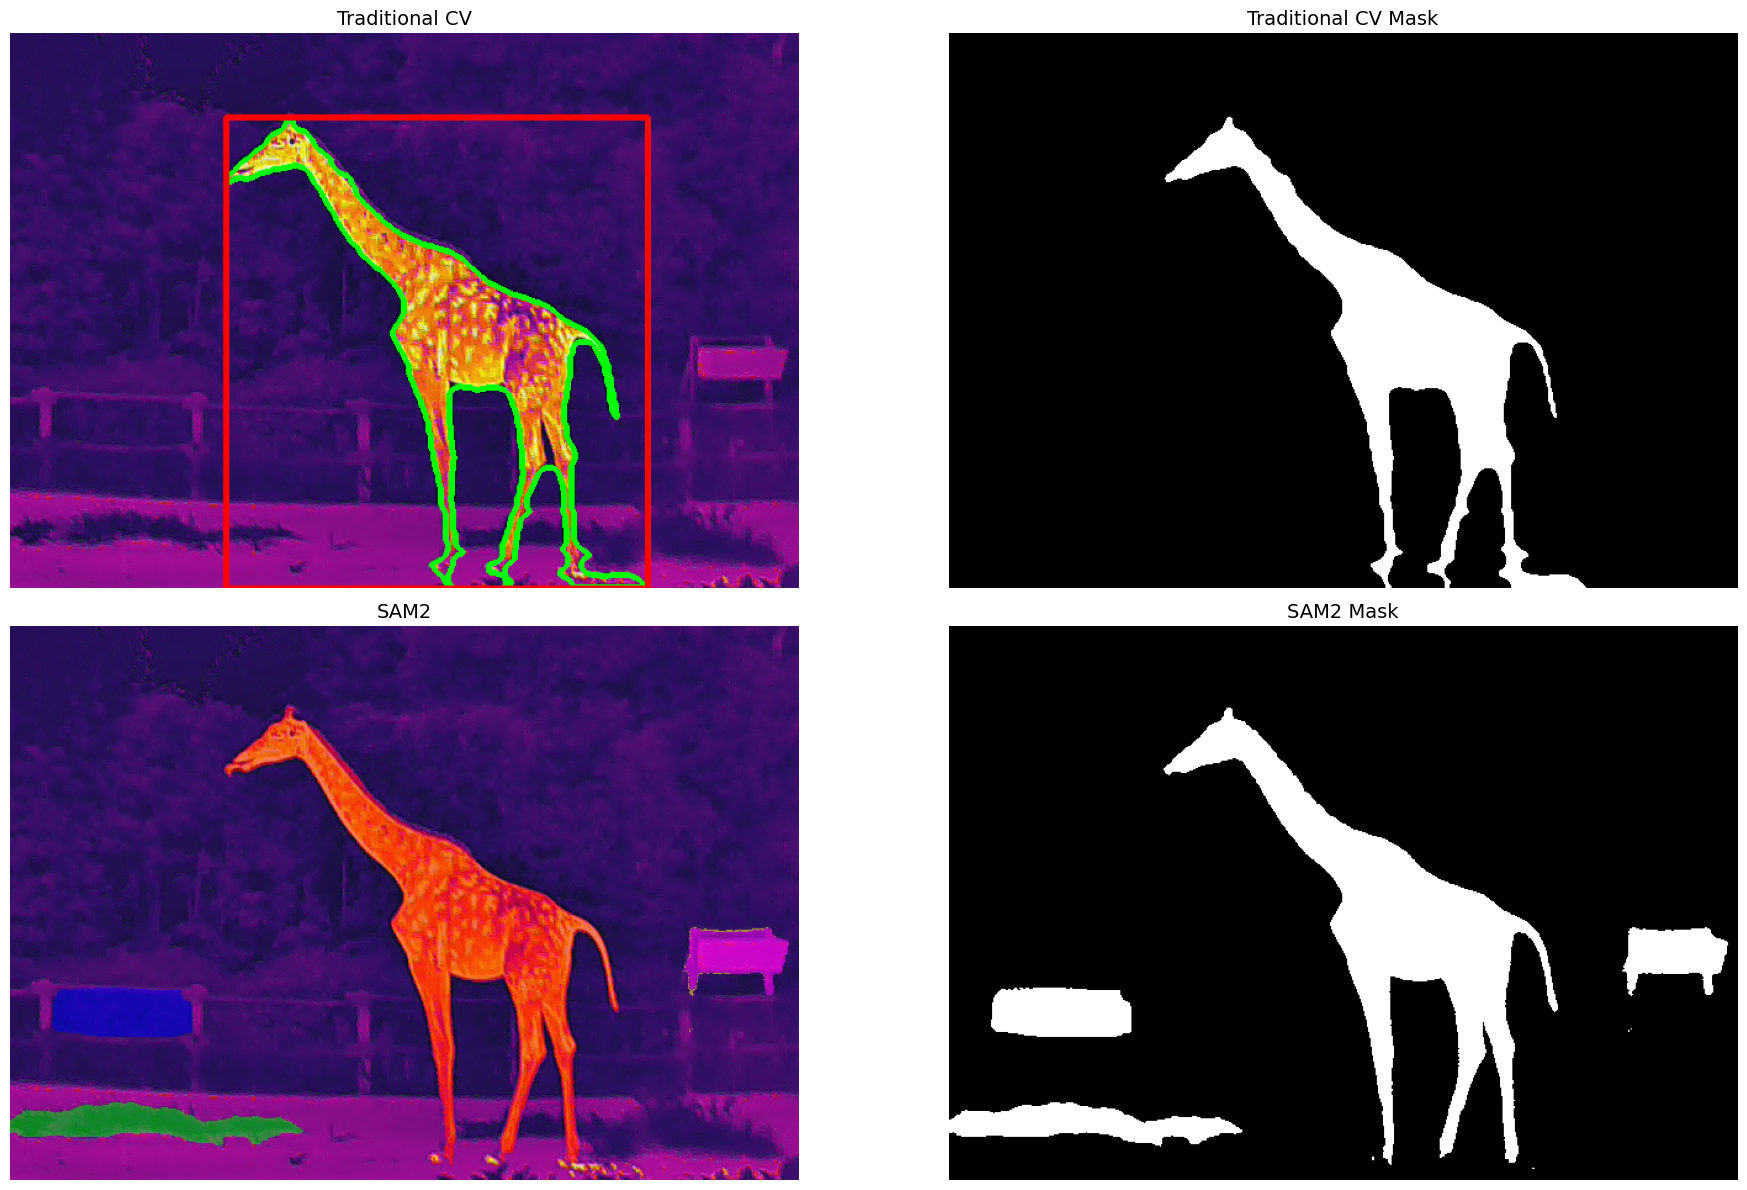


Comparison Metrics:
IoU: 0.6149
Dice: 0.7616


In [161]:
if sam2_available:
    # Side-by-side comparison
    fig, axes = plt.subplots(2, 2, figsize=(figure_width, figure_height))
    
    axes[0, 0].imshow(traditional_result)
    axes[0, 0].set_title('Traditional CV', fontsize=14)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(traditional_mask, cmap='gray')
    axes[0, 1].set_title('Traditional CV Mask', fontsize=14)
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(sam2_visual)
    axes[1, 0].set_title('SAM2', fontsize=14)
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(sam2_mask, cmap='gray')
    axes[1, 1].set_title('SAM2 Mask', fontsize=14)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate metrics
    intersection = np.logical_and(traditional_mask == 255, sam2_mask == 255)
    union = np.logical_or(traditional_mask == 255, sam2_mask == 255)
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    dice = 2 * np.sum(intersection) / (np.sum(traditional_mask==255) + np.sum(sam2_mask==255))
    
    print(f"\nComparison Metrics:")
    print(f"IoU: {iou:.4f}")
    print(f"Dice: {dice:.4f}")